In [174]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [175]:
data_file = "../csv/metro/Metro_Interstate_Traffic_Volume.csv"
dataset = pd.read_csv(data_file, index_col='date_time', usecols=['traffic_volume', 'date_time', 'holiday', 'temp'])
ds = dataset.copy()
ds

,holiday,temp,traffic_volume
date_time,,,
2012-10-02 09:00:00,None,288.28,5545
2012-10-02 10:00:00,None,289.36,4516
2012-10-02 11:00:00,None,289.58,4767
2012-10-02 12:00:00,None,290.13,5026
2012-10-02 13:00:00,None,291.14,4918
...,...,...,...
2018-09-30 19:00:00,None,283.45,3543
2018-09-30 20:00:00,None,282.76,2781
2018-09-30 21:00:00,None,282.73,2159


In [176]:
ds.drop_duplicates(inplace=True)

In [177]:
ds.sort_index

<bound method DataFrame.sort_index of                     holiday    temp  traffic_volume
date_time                                          
2012-10-02 09:00:00    None  288.28            5545
2012-10-02 10:00:00    None  289.36            4516
2012-10-02 11:00:00    None  289.58            4767
2012-10-02 12:00:00    None  290.13            5026
2012-10-02 13:00:00    None  291.14            4918
...                     ...     ...             ...
2018-09-30 19:00:00    None  283.45            3543
2018-09-30 20:00:00    None  282.76            2781
2018-09-30 21:00:00    None  282.73            2159
2018-09-30 22:00:00    None  282.09            1450
2018-09-30 23:00:00    None  282.12             954

[40606 rows x 3 columns]>

### Проверим, являются ли интервалы равномерными

In [178]:
from datetime import datetime 

def are_intervals_smooth(data):
    is_smooth = True
    not_smooth_interval_count = 0
    sorted_ds = data.sort_index()
    intervals= []
    for first, second in zip(sorted_ds.iloc[0::, :].index, sorted_ds.iloc[1::, :].index):
        first = datetime.strptime(first, '%Y-%m-%d %H:%M:%S')
        second = datetime.strptime(second, '%Y-%m-%d %H:%M:%S')
        if (second - first).seconds // 3600 > 1:
            intervals.append((second - first).seconds // 3600)
            is_smooth = False
            not_smooth_interval_count = not_smooth_interval_count + 1
    if intervals:
        print(max(intervals))
    return (is_smooth, not_smooth_interval_count)
        
print(are_intervals_smooth(ds))

23
(False, 2625)


### Пройдем по всем интервалам, если такой записи нет, добавим, потом с помощью интерполяции заполним пропуски

In [179]:
import tqdm

def get_datetime_str(dt):
    return 

date_times =[]
for interval in tqdm.tqdm(pd.date_range(min(ds.index), max(ds.index),freq="H")):
    if str(interval) not in ds.index:
        date_times.append(interval.strftime('%Y-%m-%d %H:%M:%S'))

data = pd.DataFrame.from_dict({'date_time': np.array(date_times),
                               'holiday':np.array([np.nan] * len(date_times)),
                               'temp': np.array([np.nan] * len(date_times) ),
                               'traffic_volume':np.array([np.nan] * len(date_times))})
data = data.set_index('date_time')
ds = ds.append(data)
print(are_intervals_smooth(ds))     

100%|██████████| 52551/52551 [00:00<00:00, 156085.49it/s]


(True, 0)


In [180]:
ds = ds[~ds.index.duplicated(keep='first')]

In [181]:
ds['traffic_volume'] = ds.sort_index()['traffic_volume'].interpolate(limit_direction='both')

In [182]:
ds['temp'] = ds.sort_index()['temp'].interpolate(limit_direction='both')

### Посмотрим на временной ряд в разных масштабах

In [183]:
def show_plot(data, size=(20,7), show_ticks=True, title = None):
    plt.figure(figsize=size)
    sns.lineplot(x=data.index, y=data['traffic_volume'])
    if show_ticks:
        plt.xticks(data.index[::int(len(data)/10)])
    else:
        plt.xticks([])
    if title:
        plt.title(title)
    plt.show()

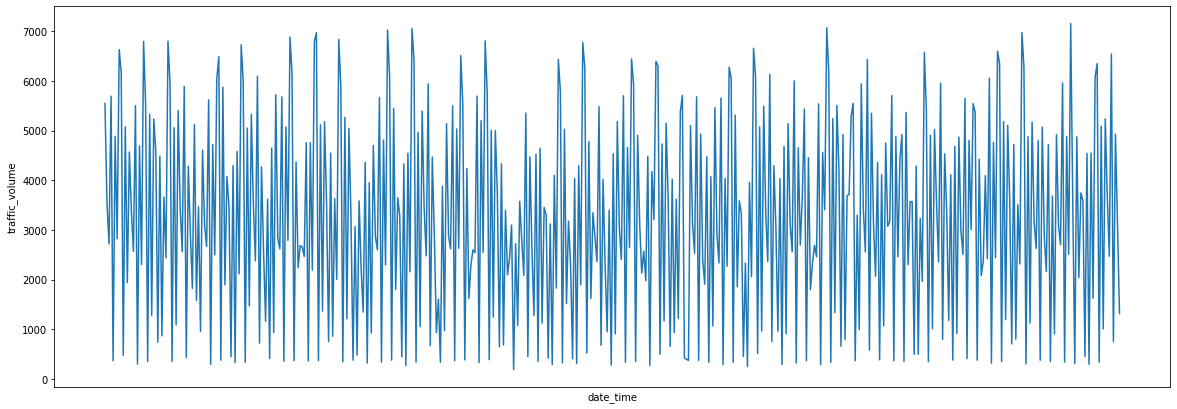

In [184]:
show_plot(data = ds.sort_index(ascending=True).iloc[:5000:10, :], show_ticks=False)

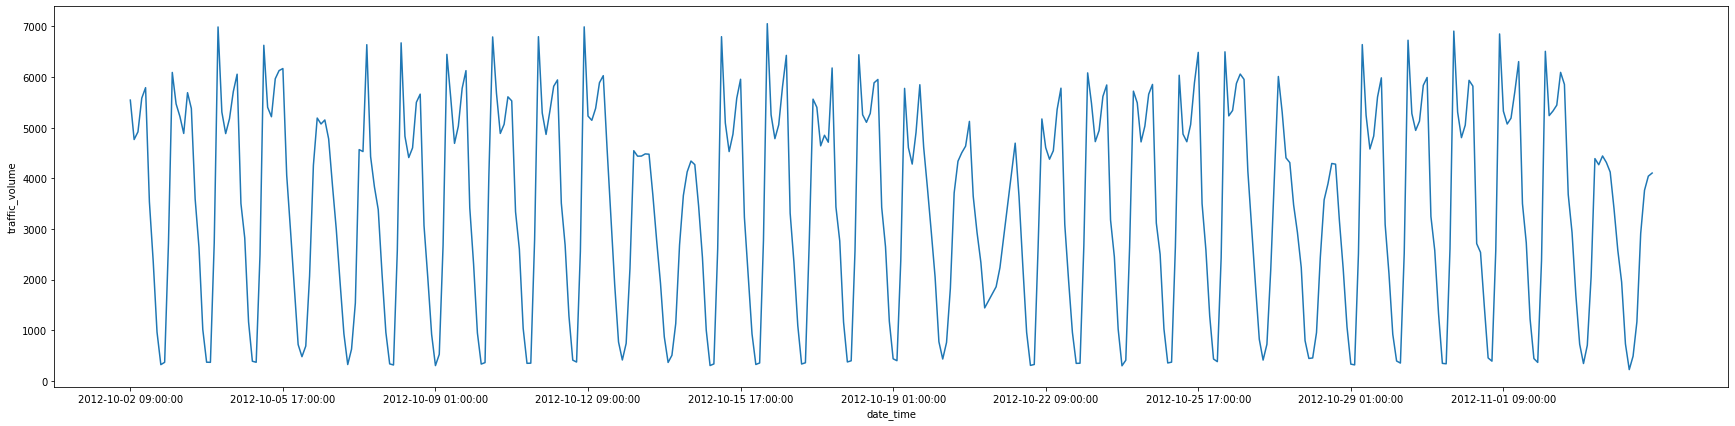

In [185]:
show_plot(data = ds.sort_index(ascending=True).iloc[:800:2, :], show_ticks=True, size=(30,7))

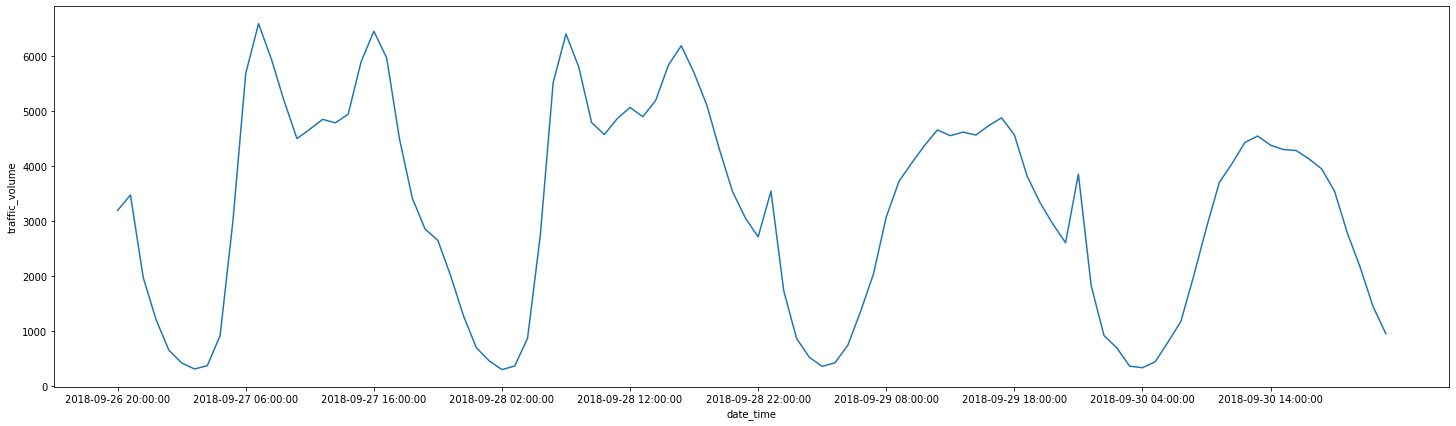

In [186]:
show_plot(data = ds.sort_index(ascending=True).iloc[-100::1, :],size=(25,7))

### Тут хорошо прослеживаются дневные колебания, видно, что в день наблюдаются два пика: утром и вечером. Ночью траффик почти нулевой

In [187]:
ds[~(ds['holiday'] == "None")].head(15)

,holiday,temp,traffic_volume
date_time,,,
2012-10-08 00:00:00,Columbus Day,273.08,455.0
2012-11-12 00:00:00,Veterans Day,288.12,1000.0
2012-11-22 00:00:00,Thanksgiving Day,278.54,919.0
2012-12-25 00:00:00,Christmas Day,264.40,803.0
2013-01-01 00:00:00,New Years Day,263.49,1439.0
2013-02-18 00:00:00,Washingtons Birthday,258.96,556.0
2013-05-27 00:00:00,Memorial Day,286.37,863.0
2013-07-04 00:00:00,Independence Day,290.08,1060.0
2013-08-22 00:00:00,State Fair,297.42,661.0


### Странно, что иногда Новый год стоит 2 января, или рождество 26. Проставим Новый год, Рождество, День независимости, а отстальные None, т.к. похоже у них плавающие даты

In [188]:
for christmas_day in pd.date_range(datetime.fromisoformat('2012-12-25 00:00:00'), datetime.fromisoformat('2018-12-25 00:00:00'),freq="Y"):
    if christmas_day not in ds:
        break
    if np.isnan(ds[christmas_day]['holiday']):
        ds[christmas_day]['holiday'] = 'Christmas Day'

for new_year in pd.date_range(datetime.fromisoformat('2013-01-01 00:00:00'), datetime.fromisoformat('2019-01-01 00:00:00'),freq="Y"):
    if new_year not in ds:
        break
    if np.isnan(ds[new_year]['holiday']):
        ds[new_year]['holiday'] = 'New Years Day'
        
for independence_day in pd.date_range(datetime.fromisoformat('2013-07-04 00:00:00'), datetime.fromisoformat('2019-07-04 00:00:00'),freq="Y"):
    if independence_day not in ds:
        break
    if np.isnan(ds[independence_day]['holiday']):
        ds[independence_day]['holiday'] = 'Independence Day'
        
ds['holiday'].fillna('None', inplace=True)

In [189]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52551 entries, 2012-10-02 09:00:00 to 2018-09-04 05:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         52551 non-null  object 
 1   temp            52551 non-null  float64
 2   traffic_volume  52551 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.6+ MB


### Посмотрим на трафик перед рождеством

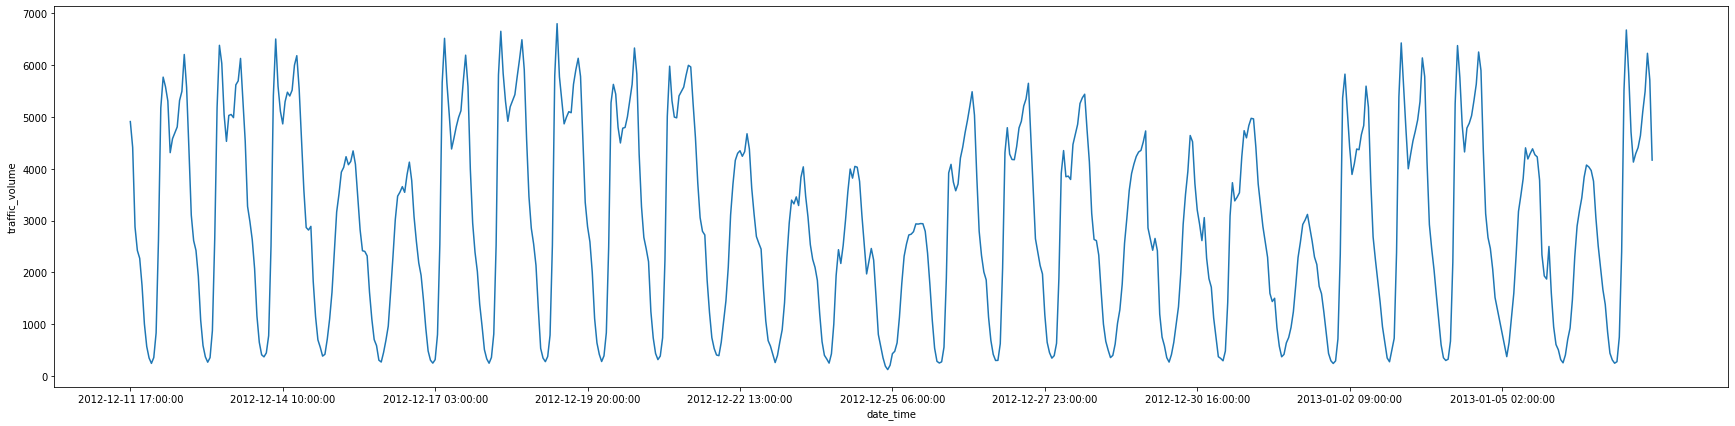

In [190]:
christmas_index = ds.index.get_loc('2012-12-25 00:00:00')
show_plot(data = ds.sort_index(ascending=True).iloc[(christmas_index - 250):christmas_index + 400],size=(30,7))

### Видно, что в рождество и в новый год трафик падет примерно в два раза и за три для до рождества наблюдается постепенный спад. 

### Проверим еще данные на выбросы

<AxesSubplot:>

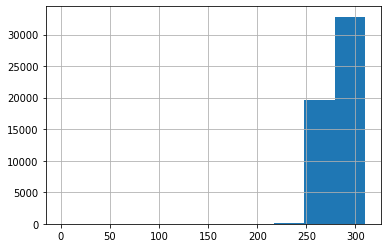

In [191]:
ds['temp'].hist()

<AxesSubplot:>

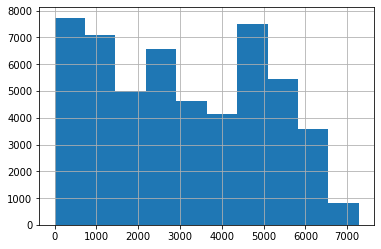

In [192]:
ds['traffic_volume'].hist()

### Выдим что у температуры есть выброс, либо в какой-то из дней температура была 0 по Кельвину. Заменим средними значениями все что ниже 200 (данные из Миннесоты, думаю, до -40 еще может быть, ниже уже врядли)

<AxesSubplot:>

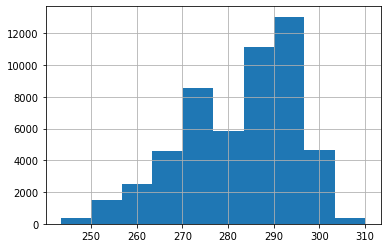

In [193]:
ds['temp'] = ds['temp'].apply(lambda x: x if x > 200 else ds['temp'].mean())
ds['temp'].hist()

### Добавим еще признак является ли день выходным

In [194]:
ds['weekend'] = ds.index.map(lambda x: 0 if datetime.fromisoformat(x).weekday() < 6 else 1)

In [195]:
ds['is_holiday'] = ds['holiday'].apply(lambda x: x != "None")

In [196]:
ds['sin_time'] = ds.index.map(lambda x: np.sin(2 * np.pi * datetime.fromisoformat(x).hour / 24))
ds['cos_time'] =  ds.index.map(lambda x: np.cos(2 * np.pi * datetime.fromisoformat(x).hour / 24))

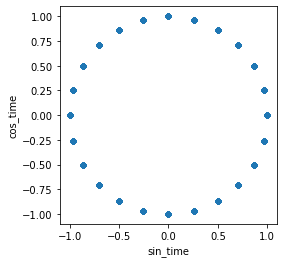

In [197]:
ds.plot.scatter('sin_time','cos_time').set_aspect('equal')

In [198]:
for i in range(6, 25):
    ds["lag_{}".format(i)] = ds['traffic_volume'].shift(i)
    
# Weekly lag
ds["lag_{}".format(24*7)] = ds['traffic_volume'].shift(24*7)

In [199]:
ds[ds['holiday'] != 'None'].head(10)

,holiday,temp,traffic_volume,weekend,is_holiday,sin_time,cos_time,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_168
date_time,,,,,,,,,,,,,,,,,,,,,
2012-10-08 00:00:00,Columbus Day,273.08,455.0,0,True,0.0,1.0,4015.0,3833.0,4329.0,...,2232.0,1539.0,1508.0,627.0,312.0,323.0,1233.0,1941.0,3202.0,NaN
2012-11-12 00:00:00,Veterans Day,288.12,1000.0,0,True,0.0,1.0,3636.0,4169.0,4012.0,...,1120.0,793.0,462.0,304.0,331.0,626.0,922.0,1381.0,2239.0,2446.0
2012-11-22 00:00:00,Thanksgiving Day,278.54,919.0,0,True,0.0,1.0,4179.0,4964.0,5733.0,...,5413.0,6138.0,5343.0,2489.0,746.0,412.0,269.0,399.0,667.0,2044.0
2012-12-25 00:00:00,Christmas Day,264.40,803.0,0,True,0.0,1.0,2536.0,3099.0,3759.0,...,2174.0,2440.0,1940.0,998.0,430.0,250.0,330.0,401.0,664.0,2018.0
2013-01-01 00:00:00,New Years Day,263.49,1439.0,0,True,0.0,1.0,3707.0,4419.0,4965.0,...,3382.0,3733.0,3092.0,1421.0,483.0,295.0,341.0,374.0,1126.0,2463.0
2013-02-18 00:00:00,Washingtons Birthday,258.96,556.0,0,True,0.0,1.0,3830.0,4030.0,4208.0,...,962.0,426.0,268.0,613.0,740.0,1785.0,2642.0,3045.0,2990.0,3169.0
2013-05-27 00:00:00,Memorial Day,286.37,863.0,0,True,0.0,1.0,2912.0,3180.0,3464.0,...,1549.0,1015.0,795.0,474.0,255.0,364.0,566.0,768.0,1208.0,1094.0
2013-07-04 00:00:00,Independence Day,290.08,1060.0,0,True,0.0,1.0,4579.0,5553.0,6321.0,...,5621.0,5661.0,2866.0,823.0,376.0,364.0,426.0,705.0,1311.0,3193.0
2013-08-22 00:00:00,State Fair,297.42,661.0,0,True,0.0,1.0,4940.0,6104.0,6702.0,...,6714.0,6159.0,3069.0,850.0,356.0,330.0,399.0,683.0,1167.0,6082.0


<AxesSubplot:>

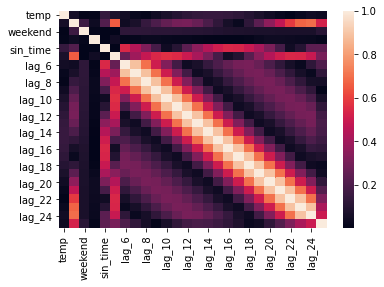

In [200]:
sns.heatmap(ds.corr().abs())

### Теперь можно начинать моделирование

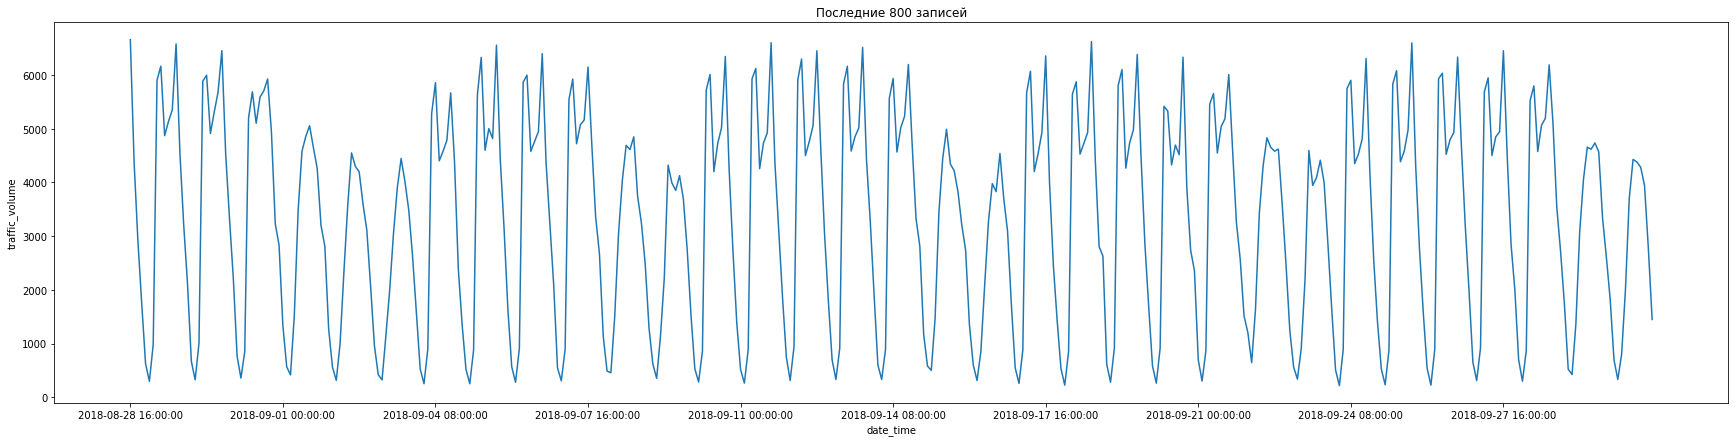

In [201]:
show_plot(data = ds.sort_index(ascending=True).iloc[-800::2, :], show_ticks=True, size=(30,7), title="Последние 800 записей")

In [202]:
hours_in_2_weeks = 24 * 14
test = ds.sort_index(ascending=True).iloc[-hours_in_2_weeks::, :]
train = ds.sort_index(ascending=True).iloc[:-hours_in_2_weeks:, :]
print("Train shape: {0} test shape: {1}".format(train.shape, test.shape))

Train shape: (52215, 27) test shape: (336, 27)


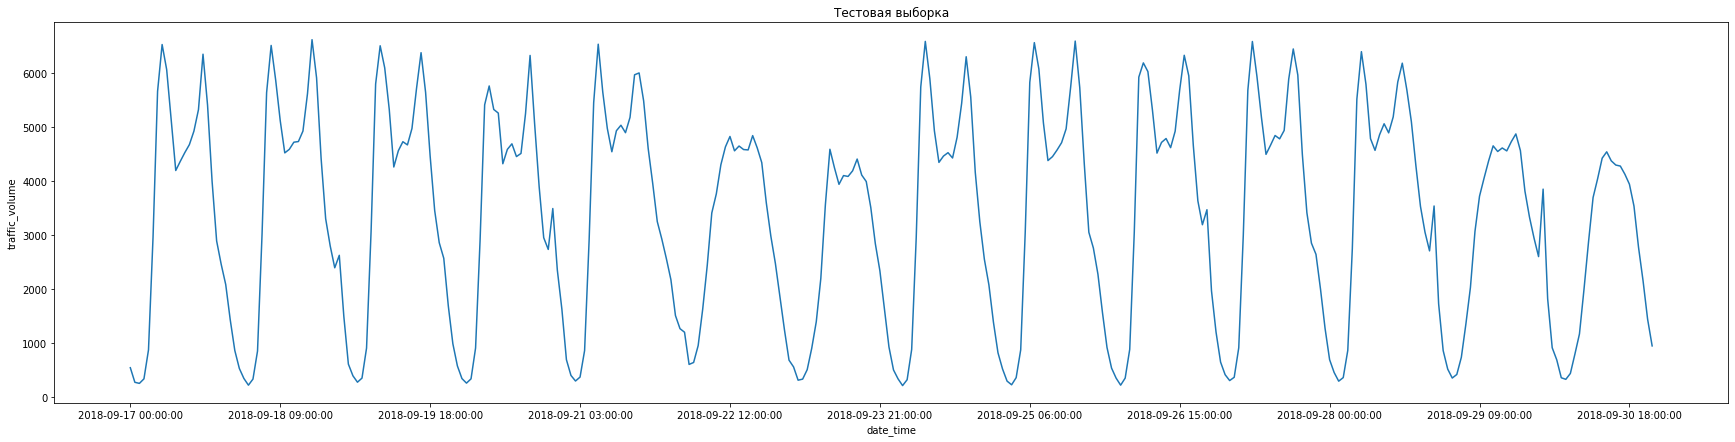

In [203]:
show_plot(data = test, show_ticks=True, size=(30,7), title="Тестовая выборка")

### Проверим ряд на стационарность

In [204]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(data):
    print("P-value: {:.2f}".format( adfuller(data)[1]))
    
dickey_fuller(test['traffic_volume'])

P-value: 0.00


### Меньше 5%, значит ряд стационарен

In [205]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

num_of_weeks = 10
model=SARIMAX(train[['traffic_volume']].iloc[-24*7* num_of_weeks::, :],seasonal_order=(0,1,0,(24*7))).fit()
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                      traffic_volume   No. Observations:                 1680
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 168)   Log Likelihood              -10699.395
Date:                             Fri, 18 Dec 2020   AIC                          21402.789
Time:                                     19:06:00   BIC                          21413.432
Sample:                                 07-09-2018   HQIC                         21406.752
                                      - 09-16-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7528      0.006    122.443      0.000       0.741       0.765
sigma2      8.191e+04   112

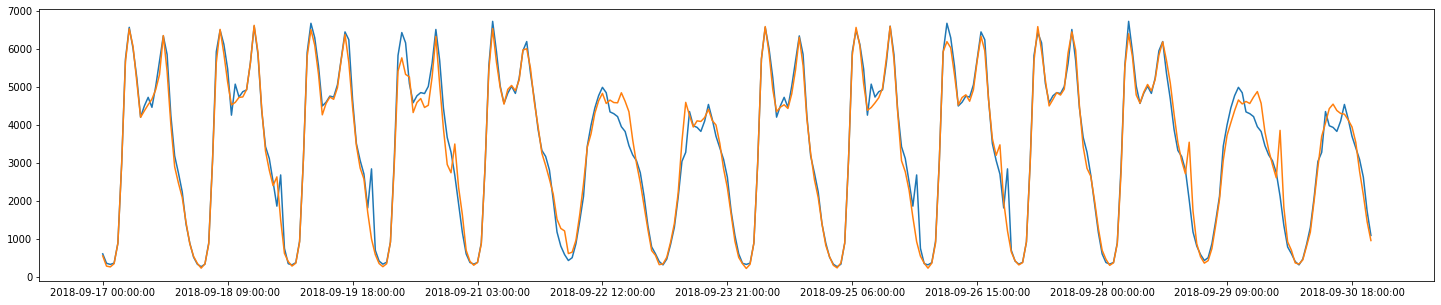

In [206]:
def show_predicted_and_actual(model, size = (25,5)):
    plt.figure(figsize=size)
    
    predicted = model.get_forecast(test.shape[0]).predicted_mean
    predicted.index = predicted.index.astype(str)
    plt.plot(predicted, label = "Predicted")
    plt.plot(test['traffic_volume'], label = "Actual")
    plt.xticks(test.index[::int(len(test.index)/10)])
    plt.show()

show_predicted_and_actual(model)

### Выглядит очень впечатляюще, немного неточно угадываются субботы, но, в принципе, очень близко

In [207]:
from tqdm import tqdm_notebook
from itertools import product  
import multiprocessing.pool
import functools

def get_params(ps, qs, Ps, Qs, ds, Ds):
    return [{'p': param[0], 'q': param[1], 'P':param[2], 'Q':param[3], 'd':param[4], 'D':param[5]} for param in list(product(ps, qs, Ps, Qs, ds, Ds))]

def RMSE(y_true, y_pred):
    if (len(y_true) != len(y_pred)):
        raise ValueError()
    return np.sqrt( sum((y_true - y_pred)**2) / len(y_true) )

def MSE(y_true, y_pred):
    if (len(y_true) != len(y_pred)):
        raise ValueError()
    return sum((y_true - y_pred)**2) / len(y_true) 

def optimizeSARIMA(ps, qs, Ps, Qs, ds, Ds, season, data, test_ds, loss_function=RMSE, verbose=True):
    best_score = None
    best_model = None
    best_params = []
    model = None
    for param in tqdm.tqdm_notebook(get_params(ps,qs,Ps,Qs,ds,Ds)):
        if verbose:
            print("Season: {}, q: {}, p: {}, Q: {}, P: {}, D: {}, d: {}".format(season, param['q'], param['p'], param['Q'], param['P'], param['D'], param['d'])) 
        try:
            model=SARIMAX(data,
                          order=(param['p'], param['d'], param['q']),
                          seasonal_order=(param['P'], param['D'], param['Q'], season)).fit()
        except KeyboardInterrupt:
            break
        except:
            continue
        error = loss_function(test_ds, model.get_forecast(test.shape[0]).predicted_mean)
        if verbose:
            print("Error: {}".format( error)) 
        if (best_score is None) or (error < best_score):
            best_params = [season, param['q'], param['p'], param['Q'], param['P'], param['D'], param['d']]
            best_score = error
            best_model = model
    if verbose:
        print("Best score is: {}".format(best_score))
    return best_model, best_score, best_params

In [208]:
num_of_weeks = 5
optimized_model, score, params = optimizeSARIMA(data=train[['traffic_volume']].iloc[-24*7* num_of_weeks::, :],
                                            loss_function=RMSE,
                                            test_ds=test['traffic_volume'],                      
                                            ps=range(0,5), 
                                            qs=[0], 
                                            Ps=[0], 
                                            Qs=[0], 
                                            ds=[1,0],
                                            Ds=[1,0], 
                                            season=24*7)

Season: 168, q: 0, p: 0, Q: 0, P: 0, D: 1, d: 1
Error: 380.8306983862164
Season: 168, q: 0, p: 0, Q: 0, P: 0, D: 0, d: 1
Error: 3012.6101535877488
Season: 168, q: 0, p: 0, Q: 0, P: 0, D: 1, d: 0
Error: 341.0657273270694
Season: 168, q: 0, p: 0, Q: 0, P: 0, D: 0, d: 0
Error: 3902.912726032163
Season: 168, q: 0, p: 1, Q: 0, P: 0, D: 1, d: 1
Error: 376.8544749430825
Season: 168, q: 0, p: 1, Q: 0, P: 0, D: 0, d: 1
Error: 3938.102606283109
Season: 168, q: 0, p: 1, Q: 0, P: 0, D: 1, d: 0
Error: 341.3231687169913
Season: 168, q: 0, p: 1, Q: 0, P: 0, D: 0, d: 0
Error: 3787.147345004531
Season: 168, q: 0, p: 2, Q: 0, P: 0, D: 1, d: 1
Error: 396.89004224215665
Season: 168, q: 0, p: 2, Q: 0, P: 0, D: 0, d: 1
Error: 2995.8346775080427
Season: 168, q: 0, p: 2, Q: 0, P: 0, D: 1, d: 0
Error: 341.1419697474802
Season: 168, q: 0, p: 2, Q: 0, P: 0, D: 0, d: 0
Error: 3913.9911166981815
Season: 168, q: 0, p: 3, Q: 0, P: 0, D: 1, d: 1
Error: 416.8318786549004
Season: 168, q: 0, p: 3, Q: 0, P: 0, D: 0, d: 1

### Некоторые параметры 0 потому, что при других значениях модель просто не могла обучиться. Выходит, что изначальные параметры были оптимальными. Попробуем другие модели и посмотрим, сможем ли мы побить результат

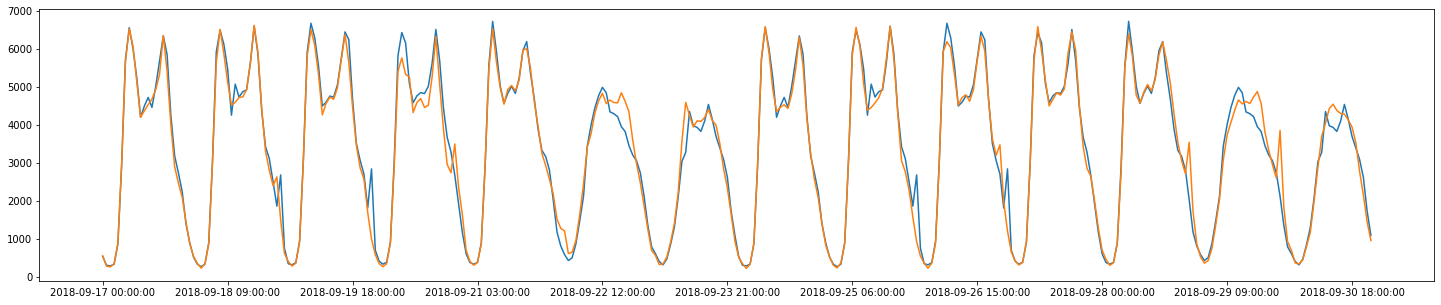

In [209]:
show_predicted_and_actual(optimized_model) 

In [210]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

### Забыли пропуски заполнить

In [211]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52551 entries, 2012-10-02 09:00:00 to 2018-09-04 05:00:00
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         52551 non-null  object 
 1   temp            52551 non-null  float64
 2   traffic_volume  52551 non-null  float64
 3   weekend         52551 non-null  int64  
 4   is_holiday      52551 non-null  bool   
 5   sin_time        52551 non-null  float64
 6   cos_time        52551 non-null  float64
 7   lag_6           52545 non-null  float64
 8   lag_7           52544 non-null  float64
 9   lag_8           52543 non-null  float64
 10  lag_9           52542 non-null  float64
 11  lag_10          52541 non-null  float64
 12  lag_11          52540 non-null  float64
 13  lag_12          52539 non-null  float64
 14  lag_13          52538 non-null  float64
 15  lag_14          52537 non-null  float64
 16  lag_15          52536 non-null  float64
 17  lag_

In [212]:
ds.drop(ds.index[:24*7], inplace=True)

In [213]:
ds.drop(columns=['holiday'], inplace=True)

In [214]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52383 entries, 2012-10-09 19:00:00 to 2018-09-04 05:00:00
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            52383 non-null  float64
 1   traffic_volume  52383 non-null  float64
 2   weekend         52383 non-null  int64  
 3   is_holiday      52383 non-null  bool   
 4   sin_time        52383 non-null  float64
 5   cos_time        52383 non-null  float64
 6   lag_6           52383 non-null  float64
 7   lag_7           52383 non-null  float64
 8   lag_8           52383 non-null  float64
 9   lag_9           52383 non-null  float64
 10  lag_10          52383 non-null  float64
 11  lag_11          52383 non-null  float64
 12  lag_12          52383 non-null  float64
 13  lag_13          52383 non-null  float64
 14  lag_14          52383 non-null  float64
 15  lag_15          52383 non-null  float64
 16  lag_16          52383 non-null  float64
 17  lag_

In [215]:
def show_metrics(model, X_train, X_test, y_train, y_test):
    print("R2 на обучающем наборе: {:.2f}".format(model.score(X_train, y_train)))
    print("R2 на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
    print("MAE: {:.2f}".format(mean_absolute_error(y_test, model.predict(X_test))))
    print("MSE: {:.2f}".format(mean_squared_error(y_test, model.predict(X_test))))
    print("RMSE: {:.2f}".format(RMSE(y_test, model.predict(X_test))))

In [216]:
def train_test_split(data, target_col, text_size=0.2):
    X_test = data.sort_index(ascending=True).iloc[-(int(len(data)*text_size))::, :]
    X_train = data.sort_index(ascending=True).iloc[:-(int(len(data)*text_size)):, :]
    y_test = X_test[target_col]
    X_test.drop(columns=[target_col], inplace=True)
    y_train = X_train[target_col]
    X_train.drop(columns=[target_col], inplace=True)
    return (X_train, X_test, y_train, y_test)
    

In [217]:
def show_predicted(y_true, y_pred, size = (25,5)):
    pred = pd.DataFrame(y_pred)
    pred.index = y_true.index
    plt.figure(figsize=size)
    plt.plot(pred, label = "Predicted")
    plt.plot(y_true, label = "Actual")
    plt.xticks([])
    plt.show()

In [218]:
X_train, X_test, y_train, y_test = train_test_split(ds, 'traffic_volume')

In [219]:
scaler = StandardScaler()
model = RidgeCV()
pipe = Pipeline([('scaler', scaler), ('model', model)])
pipe.fit(X_train, y_train)
show_metrics(pipe, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.65
R2 на тестовом наборе: 0.80
MAE: 642.43
MSE: 794389.13
RMSE: 891.29


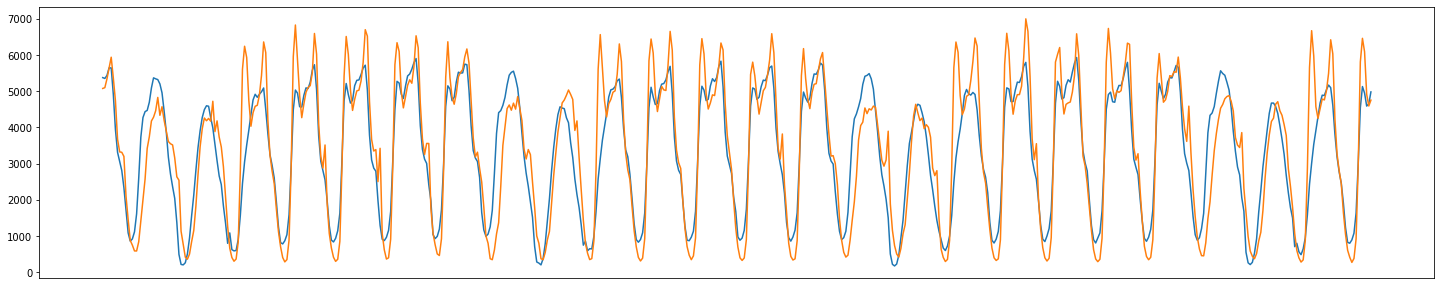

In [220]:
show_predicted(y_test[:600], pipe.predict(X_test)[:600])

In [221]:
scaler = StandardScaler()
model = LassoCV()
pipe = Pipeline([('scaler', scaler), ('model', model)])
pipe.fit(X_train, y_train)
show_metrics(pipe, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.65
R2 на тестовом наборе: 0.80
MAE: 643.95
MSE: 798619.66
RMSE: 893.66


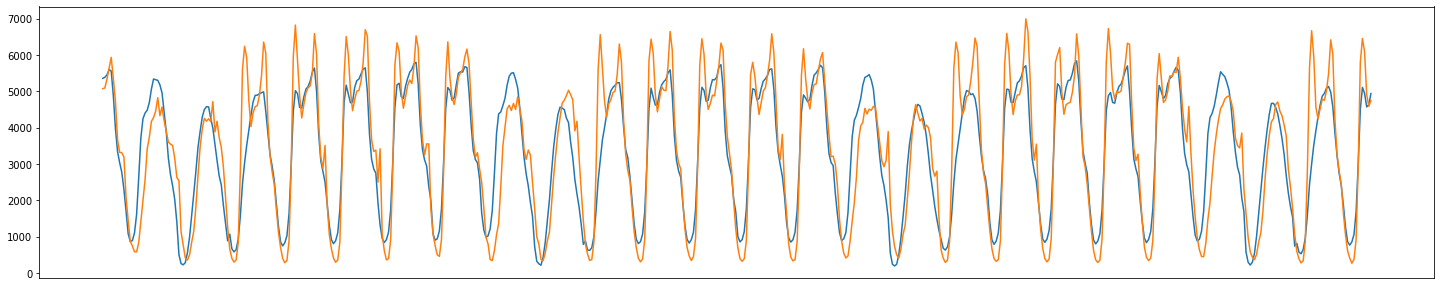

In [222]:
show_predicted(y_test[:600], pipe.predict(X_test)[:600])

In [223]:
poly = PolynomialFeatures(3)
scaler = StandardScaler()
model = RidgeCV()
pipe = Pipeline([('poly', poly),('scaler', scaler), ('model', model)])
pipe.fit(X_train, y_train)
show_metrics(pipe, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.89
R2 на тестовом наборе: 0.93
MAE: 332.55
MSE: 273189.57
RMSE: 522.68


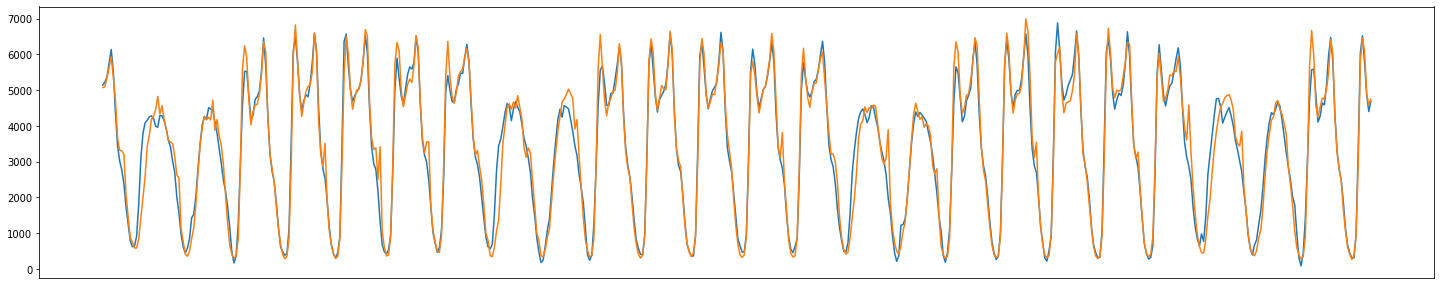

In [224]:
show_predicted(y_test[:600], pipe.predict(X_test)[:600])

### Полиномиальная регрессия дает неплохой результат, обычная плохо подстаривается под часовые пики

R2 на обучающем наборе: 0.99
R2 на тестовом наборе: 0.95
MAE: 246.15
MSE: 177861.17
RMSE: 421.74


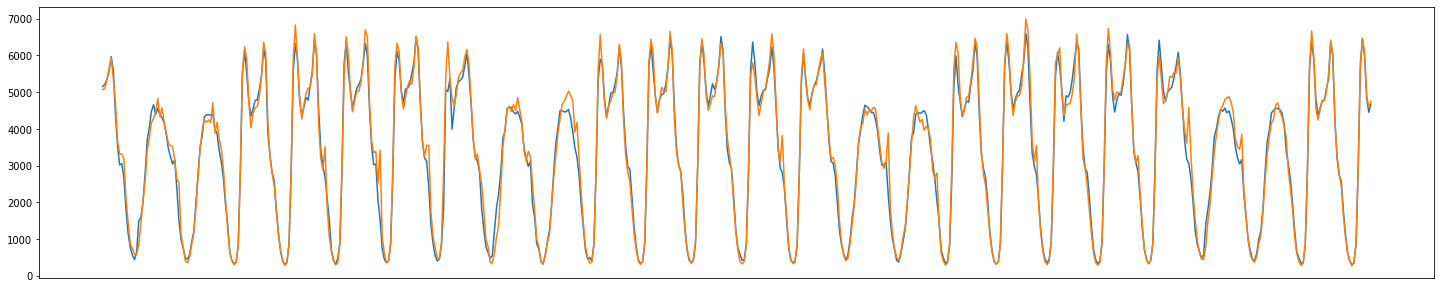

In [227]:
X_train, X_test, y_train, y_test = train_test_split(ds, 'traffic_volume')
model = RandomForestRegressor()
pipe = Pipeline([('model', model)])
pipe.fit(X_train, y_train)
show_metrics(pipe, X_train, X_test, y_train, y_test)
show_predicted(y_test[:600], pipe.predict(X_test)[:600])

<AxesSubplot:>

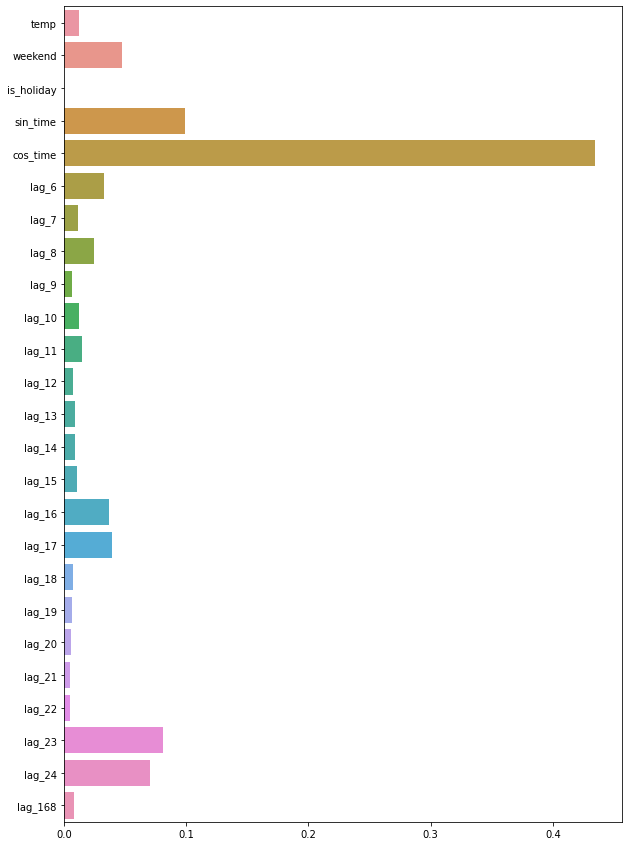

In [228]:
plt.figure(figsize=(10,15))
sns.barplot(x=model.feature_importances_, y = X_train.columns)

R2 на обучающем наборе: 0.98
R2 на тестовом наборе: 0.96
MAE: 243.90
MSE: 157406.46
RMSE: 396.74


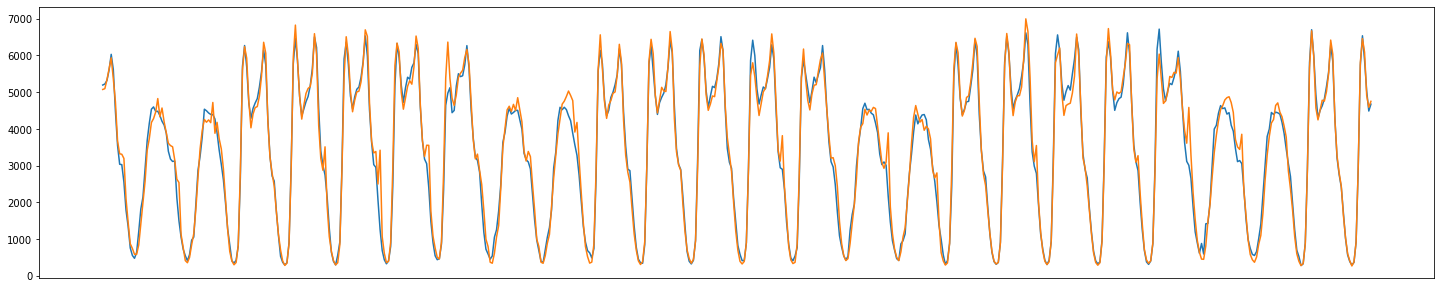

In [239]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(max_depth=10)
cat.fit(X_train, y_train, silent=True)
show_metrics(cat, X_train, X_test, y_train, y_test)
show_predicted(y_test[:600], cat.predict(X_test)[:600])

### Посмотрим какие результаты мы можем получить если будем прогнозировать по среднему значению

In [244]:
ds['day_of_week'] = ds.index.map(lambda x: datetime.fromisoformat(x).weekday())
ds['hour'] = ds.index.map(lambda x: datetime.fromisoformat(x).hour)

In [248]:
hours_in_2_weeks = 24 * 14
test = ds.sort_index(ascending=True).iloc[-hours_in_2_weeks::, :]
train = ds.sort_index(ascending=True).iloc[:-hours_in_2_weeks:, :]

In [261]:
mean = train.groupby(["day_of_week", "hour"])["traffic_volume"].mean()

850.1602298212215

In [262]:
def predict_mean(date_time):
    return mean[date_time.weekday()][date_time.hour]

In [263]:
test['naive_predict'] = test.index.map(lambda x: predict_mean(datetime.fromisoformat(x)))

In [264]:
RMSE(test['traffic_volume'], test['naive_predict'])

556.5736487133631

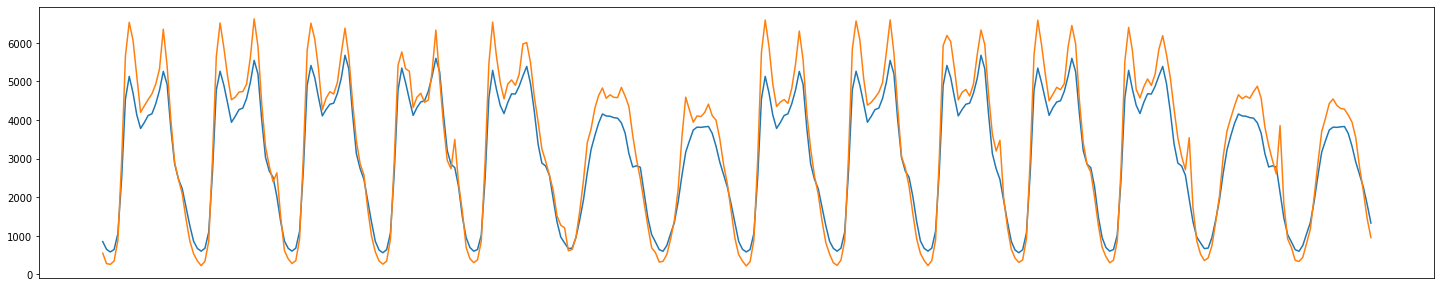

In [266]:
plt.figure(figsize=(25,5))
plt.plot(test['naive_predict'], label = "Predicted")
plt.plot(test['traffic_volume'], label = "Actual")
plt.xticks([])
plt.show()

### В итоге имеем: лучший результат RMSE: 341 у аримы, второе место у catboost, неплохой результат у random forest, а вот линейные модели в данном случае показывают плохие результаты - еле побивают baseline.
### Так же тут очень подходящий датасет для аримы, т.к. он стационарен, и подбор параметров и обработка данных почти не понадобилась, разве что пропуски заполнить.
### К сожалению, попробовать gluonts не получилось - не получилось установить библиотеку(возможно, какие-то конфликты версий питона или зависимостей)